# Importazione delle librerie utilizzate

In [1]:
import skimage
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

# Disabilito il limite di caricamento per immagini di grandi dimensioni 
Image.MAX_IMAGE_PIXELS = None

import os

from skimage import data, filters, feature, measure, morphology, segmentation, color
from scipy.ndimage import distance_transform_edt
from sklearn.cluster import KMeans

import pandas as pd
import csv
import string
import shutil

# Definizione del metodo di divisione dell'immagine


In [2]:
def crop(source_image, height_box, width_box):
    # Assegna alle due variabili le dimensioni dell'immagine
    imgwidth, imgheight = source_image.size

    # Contatore per numerare le tiles nella cartella di destinazione
    k = 1
    
    for row in range(0, imgheight, height_box):
        for column in range(0, imgwidth, width_box):
            # Creo un riquadro con le coordinate ricavate dai dati
            box = (column, row, column + width_box, row + height_box)
                            
            # Mi assicuro di non creare tile che non vadano oltre le dimensioni massime dell'immagine, in modo da non inserire
            # quelle bande nere laterali e inferiori
            if(column + width_box < imgwidth and row + height_box < imgheight):
                # Creo un riquadro con le coordinate ricavate dai dati
                box = (column, row, column + width_box, row + height_box)
                
            elif (column + width_box > imgwidth and row + height_box < imgheight):
                # Creo un riquadro con le coordinate ricavate dai dati, ma l'ultima colonna tagliata
                box = (column, row, imgwidth, row + height_box)
                
            elif (column + width_box < imgwidth and row + height_box > imgheight):
                 # Creo un riquadro con le coordinate ricavate dai dati, ma l'ultima riga tagliata
                box = (column, row, column + width_box, imgheight)
                
            elif (column + width_box > imgwidth and row + height_box > imgheight):
                 # Creo un riquadro con le coordinate ricavate dai dati, ma l'ultima colonna e riga tagliata
                box = (column, row, imgwidth, imgheight)
                           
                
            # Utilizzo le precedenti coordinate per creare il tile
            tile = source_image.crop(box)

            # Creo la cartella di destinazione in caso non esista
            if not os.path.exists("Tiles"):
                os.makedirs("Tiles")
        
            # Salvo il riquadro (colonne x righe)
            tile.save("Tiles\\" + str(k) + ".jp2")

            # Incremento il contatore
            k += 1


# Plot dell'immagine intera divisa in tile e catalogata - Pre

In [3]:
def plot_original_image(original_image):
    # Ridimensiono l'immagine
    fig = plt.figure(num=None, figsize=(8, 8), dpi=170, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1)

    # Major ticks every 1500px, minor ticks every 1500px
    major_ticks = np.arange(0, original_image.size[0], 1500)
    minor_ticks = np.arange(0, original_image.size[1], 1500)

    ax.set_xticks(major_ticks)
    ax.set_yticks(minor_ticks)

    # And a corresponding grid
    ax.grid(which='both')

    # Or if you want different settings for the grids:
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    # We change the fontsize of minor ticks label 
    plt.xticks(fontsize=7, rotation=90)
    plt.yticks(fontsize=7, rotation=0)

    # Scopro il numero di colonne nell'immagine
    how_many_x = int(original_image.size[0]/1500)
    if (original_image.size[0]%1500 != 0):
        how_many_x += 1

    # Scopro il numero di righe nell'immagine
    how_many_y = int(original_image.size[1]/1500)
    if (original_image.size[1]%1500 != 0):
        how_many_y += 1

    for j in range(how_many_y):
        y = 1500/2 + j*1500

        for i in range(how_many_x):
            x = 1500/2 + i*1500

            ax.text(x, y, '{:d}'.format((how_many_x*j + i) + 1), color = 'k', ha = 'center', va = 'center', fontsize = 5)

    plt.imshow(original_image)

# Scrittura su CSV dei conteggi

In [12]:
def csv_writer():
    # Lista dei file jp2 presenti nella cartella Tiles
    tiles = os.listdir(os.getcwd() + "\\Campione")
    
    # Creo la cartella di destinazione in caso non esista
    if not os.path.exists("CSV"):
        os.makedirs("CSV")
        with open('CSV\\mycsv_8.csv', "a") as csv_file:
            writer = csv.writer(csv_file, delimiter=',')
            writer.writerow(["object_name", "object_value"])
        
    # Mettendo la lettera 'a' al posto della 'w' posso inserire nuove righe dopo quelle già presenti invece che sovrascrivere
    with open('CSV\\mycsv_8.csv', "a") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')

        # Algoritmi di segmentazione e di conteggio applicati ad ogni file nella cartella Tiles
        for tile in tiles[:]:
            # Caricamento dell'immagine in data
            nucleus = data.load(os.getcwd() + "\\Tiles\\" + tile, True)

            # Segmentazione dei tile e conteggio dei nuclei
            cellule = segmentation(nucleus, tile)
            
            # Scrittura della stringa su file csv
            writer.writerow([tile,cellule])
            
            print("Cancellami")

# Definizione del metodo di segmentazione: Watershade

In [14]:
def segmentation(nucleus, tile):
    # Andiamo adesso a levigare la superficie dei nuclei con il submodulo filters, eliminando il rumore dei dettagli
    # Applico un median filter di grandezza 5x5 sull'immagine
    nucleus_denoised = filters.median(nucleus, selem = np.ones((8, 8)))

    # Il prossimo passo è quello di trovare i bordi delle monete 
    # Useremo il Canny Edge Detector dal submodulo feature
    edges = skimage.feature.canny(nucleus_denoised, sigma = 3)
    
    # Per applicare l'algoritmo di watershed dobbiamo convertire i bordi nell'immagine in un landscape e per questo utilizziamo
    # la distance_transform implementata in scipy nel modulo ndimage
    dt = distance_transform_edt(~edges)
    
    # Troviamo la locazione delle fontane 
    local_max = feature.peak_local_max(dt, indices = False, min_distance = 5)
    
    # Richiamiamo la stessa funzione di prima, ma questa volta con indices = True 
    # Ciò ritornerà un array con la posizione di ogni picco, invece del picco visualizzato come in figura
    peak_idx = feature.peak_local_max(dt, indices = True, min_distance = 5)
    
    # Andiamo adesso a catalogare, numerare, ogni punto. Metodo usato dal Watershade per catalogare ogni regione intorno alla 
    # fontana
    markers = measure.label(local_max)
    
    # Chiamiamo la nostra funzione di watershade sul negativo della nostra distanza dt.
    # I bordi delle monete diventeranno i picchi, mentre il corpo della moneta e lo sfondo, diventeranno landscape
    labels = morphology.watershed(-dt, markers)
    
    # Regionprops sarà calcolato per ogni immagine che vediamo
    # Per ogni regionprops possiamo adesso calcolare l'area, il bounding box, l'area del bounding box, il centroide...
    regions = measure.regionprops(labels, intensity_image = nucleus_denoised)
    
    # Calcoliamo l'intensità media per ciascuna di queste regioni 
    region_means = [r.mean_intensity for r in regions]
    
    # Paramentro utilizzato per il controllo della funzione fit. Se questa non può essere applicata a causa dell'esistenza 
    # di un solo cluster (come ad esempio nel tile 69_[8][6].jp2) la funzione non rilascia un risultato. 
    is_fitted = True
    
    # Con questo if vado a controllare se l'immagine analizzata ha elementi di rilievo. In caso contrario, 
    # non procede nelle operazioni e non fa morire il programma   
    # TODO: La rilevazione di un'immagine piatta probabilmente può avvenire anche prima
    # TODO: Queste immagini piatte non compaiono all'interno delle statistiche finali, forse si potrebbe 
    #       far in modo da includerle con risultato zero 
    if region_means:
        # Chiediamo a KMeans che siamo interessati a due cluster
        model = KMeans(n_clusters = 2)
        
        # Convertiamo le informazioni ricavate in un array 
        region_means = np.array(region_means).reshape(-1, 1)
        
        try:
            model.fit(region_means)

            # Adesso calcoliamo il valore centrale dei due cluster trovati
            # print(model.cluster_centers_)

        except ValueError as e:
            print('Failed: '+ str(e))
            is_fitted = False
        except AttributeError as w:
            print('Failed: '+ str(e))
            is_fitted = False
            
        if(is_fitted):
            # Adesso calcoliamo il valore centrale dei due cluster trovati
            bg_fg_labels = model.predict(region_means)

            # Chiediamo adesso al nostro modello di predire le label per ogni regione 
            classified_labels = labels.copy()

            # Useremo poi la combinazione tra le nostre etichette predette con le diverse regioni e le riclassificheremo 
            # secondo le coordinate di ogni regione, e assegneremo un valore di background o foreground 
            for bg_fg, region in zip(bg_fg_labels, regions):
                classified_labels[tuple(region.coords.T)] = bg_fg

            result = color.label2rgb(classified_labels, image = nucleus_denoised)
            cells = counter(result, tile)        

            return(cells)

# Definizione del metodo di conteggio

In [6]:
# Dopo aver definito i due cluster, adesso posso definire a quale categoria appartiene ogni sezione dell'immagine 

def counter(result, tile):
    
    rows, cols, bands = result.shape
    X = result.reshape(rows*cols, bands)
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    labels_div = kmeans.labels_.reshape(rows, cols)

    nucleus = 0

    # Ho diviso ogni componente dell'immagine tra due sezioni. Lo sfondo dell'immagine dovrebbe essere classificato 
    # come unico elemento o comunque dovrebbe avere un valore di molto minore rispetto alla somma dei corpuscoli in evidenza
    for i in np.unique(labels_div):
        blobs = np.int_(morphology.binary_opening(labels_div == i))
        count = len(np.unique(measure.label(blobs))) - 1
        if count > nucleus:
            nucleus = count
            
    return(nucleus)

# Ordinamento CSV in ordine di decrescente di numeri di nuclei 

In [7]:
def nucleus_sort():
    # Copio temporaneamnet il contenuto del file CSV a partire dalla seconda riga
    df = pd.read_csv('CSV\\mycsv_8.csv', header = 0)
    
    # Ordino i dati forniti dal CSV in modo decrescente
    df = df.sort_values('object_value', ascending=False)
    
    # Scrivo i dati raccolti e ordinati in un secondo file CSV
    df.to_csv('CSV\\sorted_mycsv_8.csv', index=False)

# Creazione di uno spazio ospitante le tiles con più nuclei cellulari

In [19]:
# Creazione della cartella che ospiterà le 50 immagini con più nuclei 
def dealing_tiles():
    df = pd.read_csv('CSV\\sorted_mycsv_8.csv')
    # Copio i dati presenti nel CSV ordinato, limitandomi ai nomi dei tile
    saved_column = df['object_name'] 
    
    index = 1
    
    if not os.path.exists("Saved"):
        os.makedirs("Saved")
    else:
        # Distruggo e ricreo la cartella di destinazione ogni volta
        shutil.rmtree("Saved")
        os.makedirs("Saved")
    
    # Copio ogni tile presente nel CSV nella cartella appena creata, rinominando il file in modo da assegnare la 
    # posizione nella cartella 
    for tile in saved_column:
        # I tile presenti nella nuova cartella devono essere i 50 più grandi 
        if(index <= 50):
            # Copio il tile
            shutil.copy(os.getcwd() + "\\Tiles\\" + tile, os.getcwd() + "\\Saved")
            # Rinomino
            shutil.move("Saved\\" + tile, "Saved\\" + str(index) + '_' + tile)
            index += 1

# Plot dell'immagine intera divisa in tile e catalogata - Post

In [9]:
def plot_final_image(original_image):
    # Ridimensiono l'immagine
    fig = plt.figure(num=None, figsize=(8, 8), dpi=170, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1)

    # Major ticks every 1500px, minor ticks every 1500px
    major_ticks = np.arange(0, original_image.size[0], 1500)
    minor_ticks = np.arange(0, original_image.size[1], 1500)

    ax.set_xticks(major_ticks)
    ax.set_yticks(minor_ticks)

    # And a corresponding grid
    ax.grid(which='both')

    # Or if you want different settings for the grids:
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    # We change the fontsize of minor ticks label 
    plt.xticks(fontsize=7, rotation=90)
    plt.yticks(fontsize=7, rotation=0)

    # Scopro il numero di colonne nell'immagine
    how_many_x = int(original_image.size[0]/1500)
    if (original_image.size[0]%1500 != 0):
        how_many_x += 1

    # Scopro il numero di righe nell'immagine
    how_many_y = int(original_image.size[1]/1500)
    if (original_image.size[1]%1500 != 0):
        how_many_y += 1
        
    dict = pd.read_csv('CSV//mycsv_8.csv', header=0, index_col=0, squeeze=True).to_dict()

    for j in range(how_many_y):
        y = 1500/2 + j*1500

        for i in range(how_many_x):
            x = 1500/2 + i*1500

            ax.text(x, y, '{:d}'.format((how_many_x*j + i) + 1), color = 'k', ha = 'center', va = 'center', fontsize = 5)
            ax.text(x, y+(250), dict.get(str((how_many_x*j + i) + 1) + '.jp2', 'nan'), color = 'k', ha = 'center', va = 'center', fontsize = 6)

    plt.imshow(original_image)

# Algoritmi di preparazione al conteggio

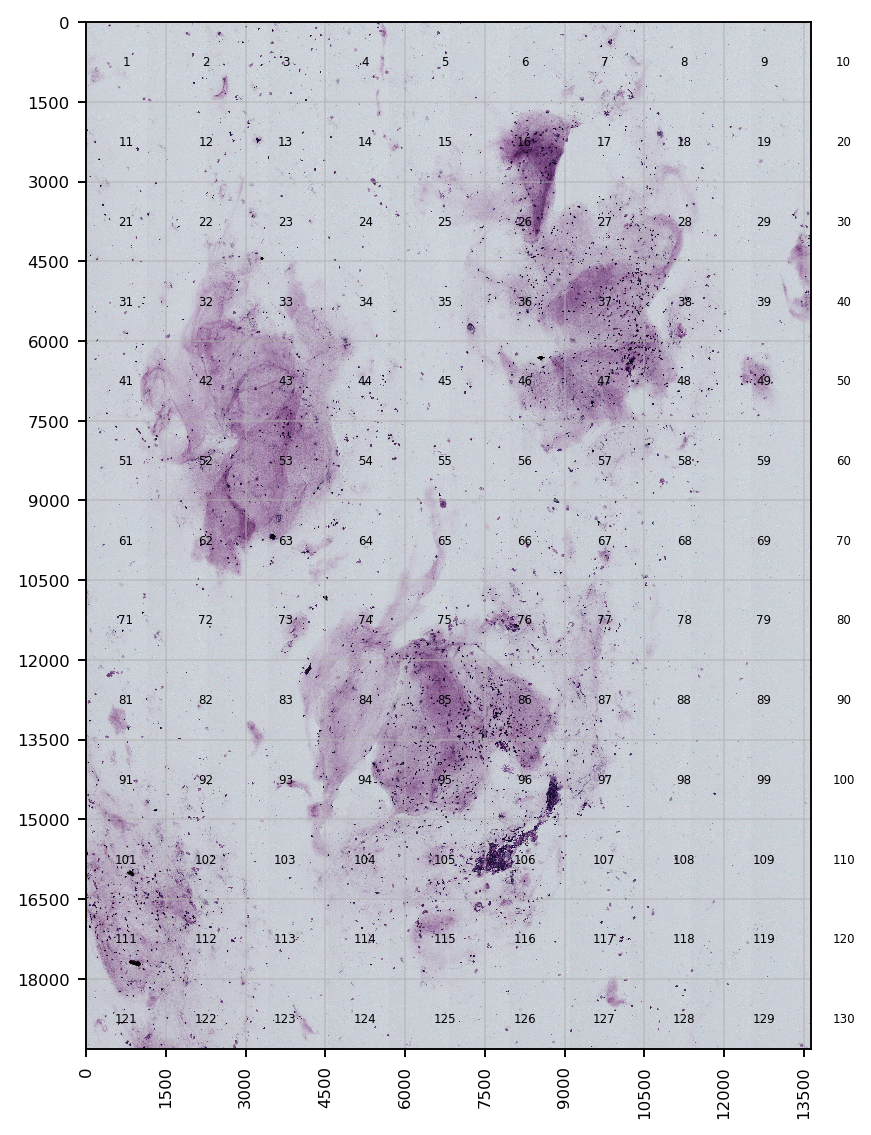

In [10]:
# Apertura dell'immagine
original_image = Image.open("Original\\striscio_completo.jp2")

# Divisione di tile delle immagini
# crop(original_image, 1500, 1500)

# Divisione e plot dell'immagine
plot_original_image(original_image)

# Applicazione degli algoritmi

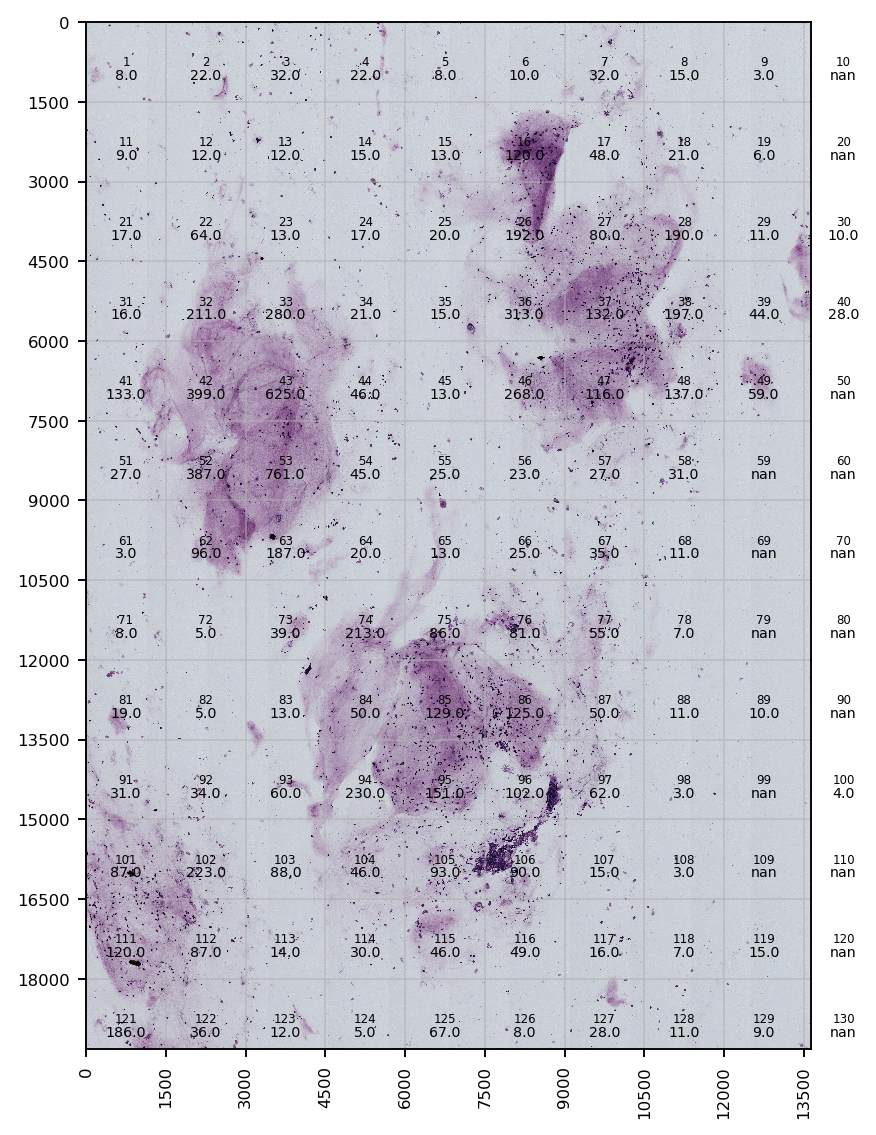

In [23]:
# Inizio delle operazioni e scrittura su CSV
# csv_writer()

# Ordino il file csv
nucleus_sort()

pd.read_csv("CSV//sorted_mycsv_8.csv").head(50)

# Spostamento in una cartella separata dei tiles contenenti più nuclei e successiva catalogazione
dealing_tiles()

plot_final_image(original_image)

# TODO List

In [ ]:
# TODO: Vedere se è possibile migliorare il riconoscimento dei nuclei

# TODO: Scrivere sul file CSV dopo ogni calcolo di nuclei per tile, in modo da non dover aspettare il calcolo di ogni tile per 
#       avere un risultato parziale

# TODO: Scrivere nell'immagine il numero di nuclei in forma intera e non decimale 

# TODO: Escogitare un modo per indicare i progressi durante l'analisi dei tile e cancellare l'attuale 'Cancellami'

# ------------------------------------- DONE
# TODO: Se si decide di eseguire lo script con pochi tile alla volta, assicurarsi di cancellare di volta in volta la cartella
#       SAVED, perchè all'interno ci saranno ancora le vecchie tiles con i vecchi titoli (classifiche vecchie)

# TODO: Scrivere il file CSV in modo sequenziale, senza cancellare le linee già scritte, in modo da poter calcolare il numero di
#       nuclei 10 tiles alla volta (sul mio PC che soffre i lunghi tempi di calcolo)

# TODO: Alla fine di tutto plottare un'altra immagine dello striscio completo, ma questa volta deve avere il numero di nuclei
#       presenti in ogni tile, oltre che il solito numero di tile 

# TODO: Quando inserisco nel csv le nuove informazioni, crea un nuovo header: risolvere